In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('student-por.csv', sep=';')

In [4]:
df.shape

(649, 33)

In [5]:
display(df.head())

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


#### Preprocess

In [6]:
target_column = 'Walc'
X = df.drop(columns=[target_column])
y = df[target_column]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

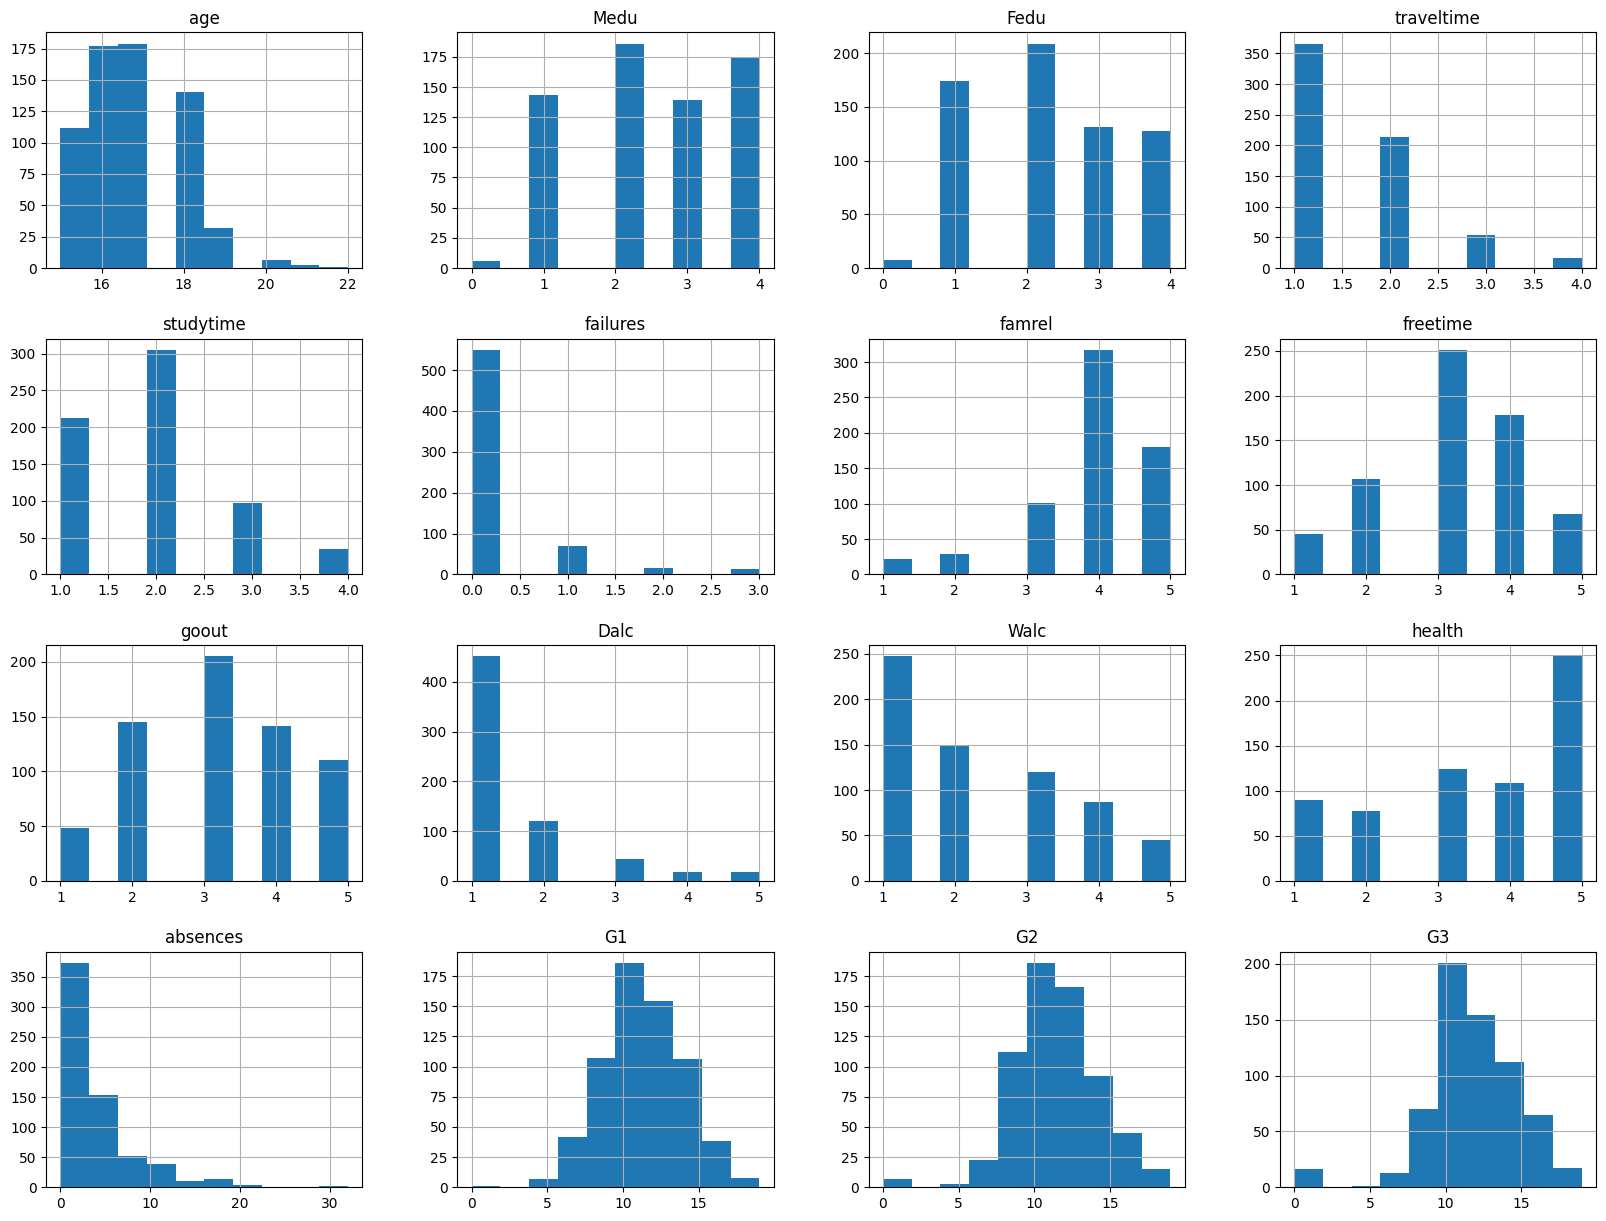

In [8]:
import matplotlib.pyplot as plt

df.hist(figsize=(20, 15))
plt.show()

<Axes: xlabel='freetime', ylabel='G3'>

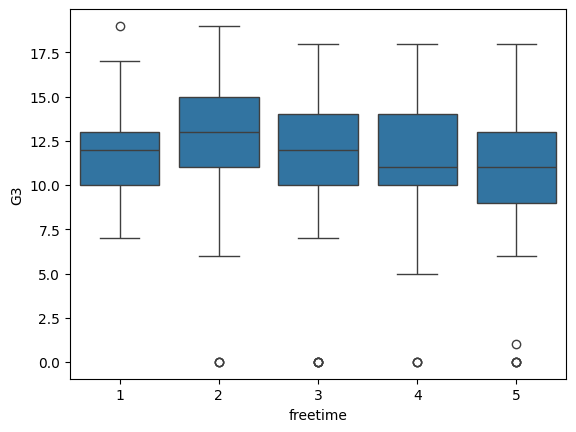

In [19]:
import seaborn as sns
sns.boxplot(data=df, x="freetime", y="G3")